In [45]:
from urllib.parse import urlencode
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import requests
import pytz
import json

DATA_TIMEZONE = pytz.timezone("America/New_York")

def get_minute_data(symbol, now):
    
    start = now.replace(hour=6, minute=30, second=0, microsecond=0)
    end = start.replace(hour=13, minute=0)
    url = "https://query1.finance.yahoo.com/v7/finance/chart/{}?period1={:.0f}&period2={:.0f}"\
          "&interval=1m&indicators=quote&includeTimestamps=true&"\
          "events=div%7Csplit%7Cearn".format(symbol, start.timestamp(), end.timestamp())
            
    page = requests.get(url)
    result = page.json()['chart']['result']
    if not result:
        print(page.json())
        return
    
    data = result[0]
    quote = data['indicators']['quote'][0]
    if 'timestamp' not in data:
        print("Error: timestamp not in data")
        return
    times = data['timestamp']
    period = data['meta']['currentTradingPeriod']['regular']
    start, end = period['start'], period['end']
    df = pd.DataFrame(quote, index=[datetime.fromtimestamp(t, tz=DATA_TIMEZONE).astimezone(now.tzinfo) for t in times])
    return df


la_tz = pytz.timezone('America/Los_Angeles')
now = datetime.now(tz=la_tz).replace(year=2019, month=3, day=1, hour=12, minute=0, second=0)
print(now)
amrn_data = get_minute_data('AMRN', now)

amrn_data[-5:]

2019-03-01 12:00:00.651153-07:00


,close,low,volume,high,open
2019-03-01 11:55:00-08:00,22.549999,22.540001,15129,22.549999,22.540001
2019-03-01 11:56:00-08:00,22.530001,22.530001,36338,22.559999,22.546801
2019-03-01 11:57:00-08:00,22.507200,22.420000,53334,22.510000,22.510000
2019-03-01 11:58:00-08:00,22.459999,22.459999,18098,22.520000,22.480000
2019-03-01 11:59:00-08:00,22.490000,22.469999,18266,22.499901,22.469999


In [3]:
now = datetime.now(tz=la_tz).replace(year=2019, month=3, day=5, hour=12, minute=0, second=0)
print(now)
cron_data = get_minute_data('CRON', now)
cron_data[-5:]

2019-03-05 12:00:00.589974-07:00


,low,close,volume,high,open
2019-03-05 11:55:00-08:00,23.320000,23.334801,38270,23.350000,23.320000
2019-03-05 11:56:00-08:00,23.340000,23.379999,40287,23.389999,23.340000
2019-03-05 11:57:00-08:00,23.380100,23.445000,92432,23.450001,23.380100
2019-03-05 11:58:00-08:00,23.450001,23.510000,158893,23.510000,23.450001
2019-03-05 11:59:00-08:00,23.425501,23.440001,62418,23.523500,23.500000


/usr/local/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


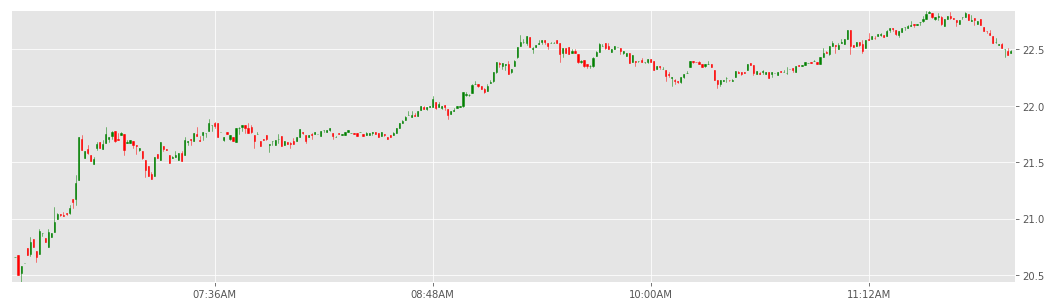

In [4]:
%matplotlib inline

from matplotlib.finance import *
import matplotlib.pyplot as plt
from matplotlib import ticker, style
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY, date2num
    
style.use('ggplot')

def plot_minute_data(data):
    if data is not None:
        fig = plt.figure(figsize=(18, 5))
        ax = plt.subplot(111)
        candlestick_ochl(
            ax, 
            ((date2num(r.Index), r.open, r.close, r.high, r.low) 
             for r in data.itertuples()), 
            width=1/3600,  
            colorup='g',  
            colordown='r',
        )

        x_min, x_max = date2num(data.index.min()) - .001, date2num(data.index.max()) + .001
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(data.low.min(), data.high.max())

        minute_formatter = DateFormatter('%I:%M%p', tz=pytz.timezone('America/Los_Angeles'))
        ax.xaxis.set_major_formatter(minute_formatter)

        ax.yaxis.tick_right()
        plt.show()

plot_minute_data(amrn_data)

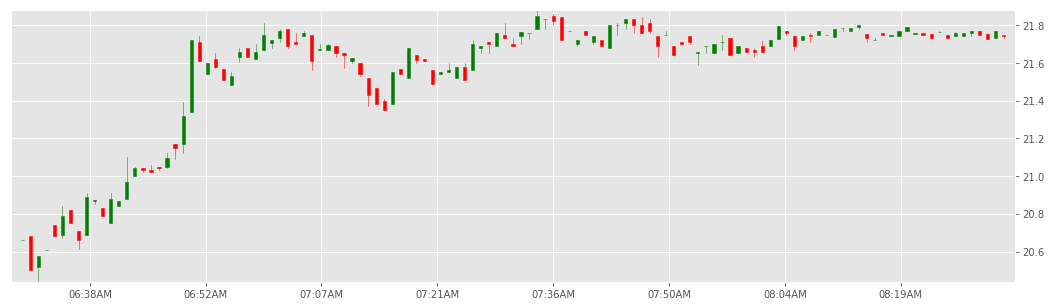

In [8]:
amrn_pattern_data = amrn_data.loc[amrn_data.index < datetime.datetime(2019, 3, 1, 8, 40, 0, tzinfo=la_tz)].copy()
plot_minute_data(amrn_pattern_data)

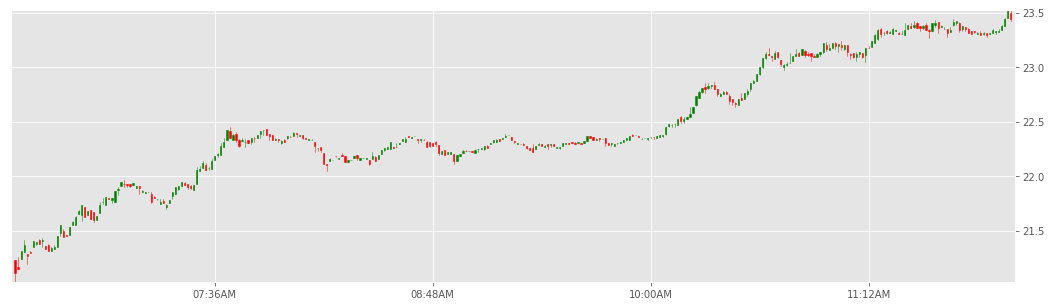

In [10]:
plot_minute_data(cron_data)

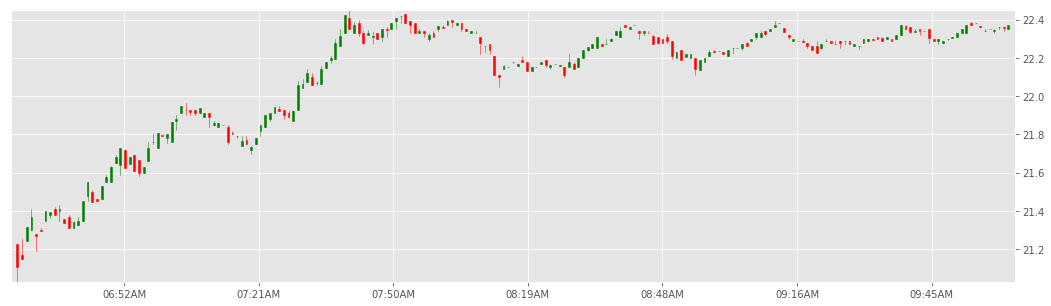

In [21]:
cron_pattern_data = cron_data.loc[cron_data.index < datetime.datetime(2019, 3, 5, 10, 10, 0, tzinfo=la_tz)].copy()
plot_minute_data(cron_pattern_data)

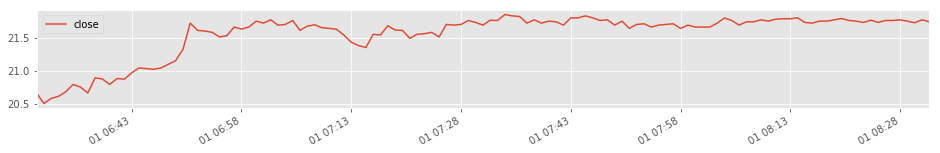

In [23]:
amrn_pattern_data[['close']].plot(figsize=(16,2))

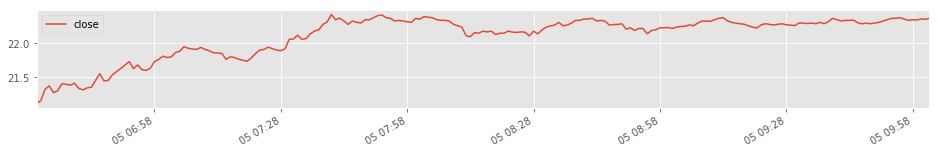

In [24]:
cron_pattern_data[['close']].plot(figsize=(16,2))

## Normalizing data

213 -> 30


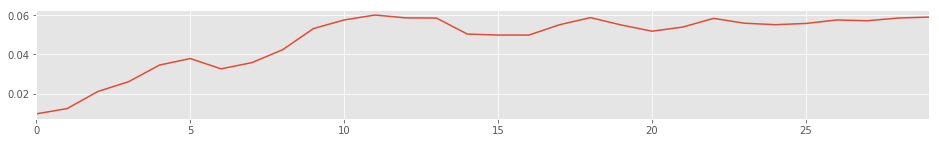

In [91]:
def normalize(data, norm_values=True, input_len=30):
    len_data = len(data)
    assert len_data >= input_len
    
    # norm values
    if norm_values:
        min_value = min(data)
        data = (data - min_value) / min_value
    
    # norm length
    coef, reminder = len_data // input_len, len_data % input_len
    
    # merge function = mean
    def merge(*args):
        return sum(args) / len(args) 
    
    # first get rid of reminder points
    if reminder:
        step = len_data // reminder
        for i in reversed(range(reminder)):
            pos_1 = step * i
            pos_2 = pos_1 + 1
            data = np.concatenate((data[:pos_1], np.array([merge(data[pos_1], data[pos_2])]), data[pos_2 + 1:]))
        
    # now squieze by coef
    data = np.array([
        merge(*data[i:i+coef])  for i in range(0, len(data), coef)
    ])
    print("{} -> {}".format(len_data, len(data)))
    return data

pd.Series(normalize(cron_pattern_data.close.values)).plot(figsize=(16,2))

123 -> 30


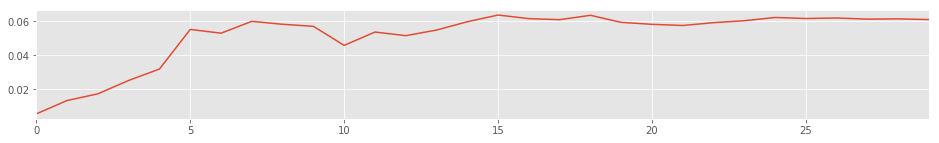

In [92]:
pd.Series(normalize(amrn_pattern_data.close.values)).plot(figsize=(16,2))

### just checking if reducing number of points works as expected

In [88]:
normalize(np.array([2, 2, 4, 4, 5, 7]), norm_values=False, input_len=3)

6 -> 3


array([2., 4., 6.])

In [81]:
normalize(np.array([2, 2, 2, 4, 4, 5, 5]), norm_values=False, input_len=3)

7 -> 3


array([2., 4., 5.])

In [87]:
normalize(np.array([2, 2, 2, 2, 4, 4, 5, 5]), norm_values=False, input_len=3)

8 -> 3


array([2., 3., 5.])

In [83]:
normalize(np.array([2, 2, 2, 2, 2, 4, 4, 5, 5]), norm_values=False, input_len=3)

9 -> 3


array([2.        , 2.66666667, 4.66666667])